# File 4: Volatility Regression
## Stock Price Volatility & Sentiment ML Project

**Purpose:** Forecast rolling 20-day volatility using regression models

**What is Volatility Forecasting?**
- Volatility measures how much stock prices fluctuate
- High volatility = more risk, more opportunity
- Predicting volatility helps with risk management and trading strategies

**Regression Task:**
- **Target:** Future volatility (Volatility_20 shifted forward)
- **Features:** Current prices, technical indicators, sentiment
- **Goal:** Minimize prediction error (RMSE, MAE)

**Models we'll train:**
1. **Linear Regression** - Simple baseline
2. **Random Forest Regressor** - Captures non-linear patterns
3. **Support Vector Regressor (SVR)** - Non-linear with kernel trick

---

## Step 1: Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✅ Libraries loaded successfully!')

✅ Libraries loaded successfully!


## Step 2: Load Final Dataset

In [2]:
print('='*70)
print('LOADING DATA FOR VOLATILITY REGRESSION')
print('='*70)

# UPDATE THIS PATH
df = pd.read_csv('/Users/aryan/Desktop/Stock-Price-Volatility-Sentiment-ML/data/final_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])

print(f'\n✅ Dataset loaded!')
print(f'   Total rows: {len(df):,}')
print(f'   Date range: {df["Date"].min().date()} to {df["Date"].max().date()}')
print(f'   Stocks: {df["Ticker"].unique()}')

# Check volatility column
print(f'\nVolatility statistics:')
print(f'   Min: {df["Volatility_20"].min():.6f}')
print(f'   Max: {df["Volatility_20"].max():.6f}')
print(f'   Mean: {df["Volatility_20"].mean():.6f}')
print(f'   Std: {df["Volatility_20"].std():.6f}')

LOADING DATA FOR VOLATILITY REGRESSION

✅ Dataset loaded!
   Total rows: 3,705
   Date range: 2020-12-31 to 2025-12-01
   Stocks: ['AAPL' 'TSLA' 'MSFT']

Volatility statistics:
   Min: 0.005960
   Max: 0.075753
   Mean: 0.022833
   Std: 0.012827


## Step 3: Create Volatility Forecasting Target

**Key Idea:**
- We want to predict **future** volatility (e.g., 5 days ahead)
- Current row features → Predict volatility 5 days later
- This is useful for risk management and position sizing

In [3]:
print('\n' + '='*70)
print('CREATING TARGET VARIABLE - FUTURE VOLATILITY')
print('='*70)

# Sort by date within each ticker
df = df.sort_values(['Ticker', 'Date']).reset_index(drop=True)

# Create target: volatility 5 days in the future
forecast_horizon = 5
df['Future_Volatility'] = df.groupby('Ticker')['Volatility_20'].shift(-forecast_horizon)

print(f'\nForecast horizon: {forecast_horizon} days')
print(f'Target variable: Future_Volatility (Volatility_20 shifted {forecast_horizon} days ahead)')

# Remove rows with NaN target (last 5 days of each stock)
df_clean = df.dropna(subset=['Future_Volatility']).copy()

print(f'\nDataset size:')
print(f'   Before removing NaN: {len(df):,} rows')
print(f'   After removing NaN: {len(df_clean):,} rows')
print(f'   Removed: {len(df) - len(df_clean)} rows (last {forecast_horizon} days per stock)')


CREATING TARGET VARIABLE - FUTURE VOLATILITY

Forecast horizon: 5 days
Target variable: Future_Volatility (Volatility_20 shifted 5 days ahead)

Dataset size:
   Before removing NaN: 3,705 rows
   After removing NaN: 3,690 rows
   Removed: 15 rows (last 5 days per stock)


## Step 4: Prepare Features and Target

In [4]:
print('\n' + '='*70)
print('PREPARING FEATURES AND TARGET')
print('='*70)

# Features to use (exclude target, metadata, and current volatility)
feature_cols = [
    # Price features
    'Close', 'Open', 'High', 'Low', 'Volume',
    # Technical indicators
    'RSI', 'EMA_20', 'EMA_50', 
    'MACD', 'MACD_Signal', 'MACD_Hist',
    'BB_Upper', 'BB_Middle', 'BB_Lower', 'BB_Width',
    # Price metrics (including current volatility)
    'Price_Change', 'Volatility_20', 'Daily_Return', 'High_Low_Range',
    # Sentiment features
    'Sentiment_Score', 'Sentiment_Positive_Ratio', 
    'Sentiment_Negative_Ratio', 'Daily_Sentiment'
]

# Separate features and target
X = df_clean[feature_cols].copy()
y = df_clean['Future_Volatility'].copy()

# Keep metadata for later
dates = df_clean['Date'].copy()
tickers = df_clean['Ticker'].copy()

print(f'✅ Features and target prepared')
print(f'   X shape: {X.shape}')
print(f'   y shape: {y.shape}')
print(f'   Number of features: {len(feature_cols)}')


PREPARING FEATURES AND TARGET
✅ Features and target prepared
   X shape: (3690, 23)
   y shape: (3690,)
   Number of features: 23


## Step 5: Train/Test Split (Time-Based)

**Important:** We use time-based split (not random) because this is time-series data.

In [5]:
print('\n' + '='*70)
print('TRAIN/TEST SPLIT (TIME-BASED)')
print('='*70)

# Create temporary dataframe for time-based split
temp_df = pd.DataFrame(X)
temp_df['Date'] = dates.values
temp_df['Target'] = y.values
temp_df['Ticker'] = tickers.values

# Sort by date
temp_df = temp_df.sort_values('Date').reset_index(drop=True)

# Split: 80% train, 20% test
split_idx = int(len(temp_df) * 0.8)

train_df = temp_df.iloc[:split_idx]
test_df = temp_df.iloc[split_idx:]

# Extract features and target
X_train = train_df[feature_cols].values
y_train = train_df['Target'].values
X_test = test_df[feature_cols].values
y_test = test_df['Target'].values

print(f'\n✅ Data split complete:')
print(f'   Total samples: {len(temp_df):,}')
print(f'   Train samples: {len(X_train):,} ({len(X_train)/len(temp_df)*100:.1f}%)')
print(f'   Test samples: {len(X_test):,} ({len(X_test)/len(temp_df)*100:.1f}%)')

print(f'\nDate ranges:')
print(f'   Train: {train_df["Date"].min().date()} to {train_df["Date"].max().date()}')
print(f'   Test: {test_df["Date"].min().date()} to {test_df["Date"].max().date()}')

print(f'\nTarget (Future Volatility) statistics:')
print(f'   Train - Mean: {y_train.mean():.6f}, Std: {y_train.std():.6f}')
print(f'   Test - Mean: {y_test.mean():.6f}, Std: {y_test.std():.6f}')


TRAIN/TEST SPLIT (TIME-BASED)

✅ Data split complete:
   Total samples: 3,690
   Train samples: 2,952 (80.0%)
   Test samples: 738 (20.0%)

Date ranges:
   Train: 2020-12-31 to 2024-11-27
   Test: 2024-11-29 to 2025-11-21

Target (Future Volatility) statistics:
   Train - Mean: 0.022569, Std: 0.012174
   Test - Mean: 0.023878, Std: 0.015140


## Step 6: Feature Scaling

Regression models benefit from scaled features, especially SVR.

In [6]:
from sklearn.preprocessing import StandardScaler

print('\n' + '='*70)
print('FEATURE SCALING')
print('='*70)

# Create and fit scaler
scaler_reg = StandardScaler()
X_train_scaled = scaler_reg.fit_transform(X_train)
X_test_scaled = scaler_reg.transform(X_test)

print('\n✅ Features scaled')
print(f'   Scaler fitted on training data')
print(f'   Applied to both train and test sets')


FEATURE SCALING

✅ Features scaled
   Scaler fitted on training data
   Applied to both train and test sets


## Step 7: Train Linear Regression

In [7]:
print('\n' + '='*70)
print('MODEL 1: LINEAR REGRESSION')
print('='*70)

print('\nTraining Linear Regression...')

# Create and train model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr_train = lr_model.predict(X_train_scaled)
y_pred_lr_test = lr_model.predict(X_test_scaled)

# Calculate metrics
rmse_lr_train = np.sqrt(mean_squared_error(y_train, y_pred_lr_train))
rmse_lr_test = np.sqrt(mean_squared_error(y_test, y_pred_lr_test))
mae_lr_test = mean_absolute_error(y_test, y_pred_lr_test)
r2_lr_test = r2_score(y_test, y_pred_lr_test)

print(f'\n✅ Linear Regression Results:')
print(f'   Training RMSE: {rmse_lr_train:.6f}')
print(f'   Testing RMSE: {rmse_lr_test:.6f}')
print(f'   Testing MAE: {mae_lr_test:.6f}')
print(f'   Testing R² Score: {r2_lr_test:.4f}')


MODEL 1: LINEAR REGRESSION

Training Linear Regression...

✅ Linear Regression Results:
   Training RMSE: 0.003637
   Testing RMSE: 0.004875
   Testing MAE: 0.003097
   Testing R² Score: 0.8963


## Step 8: Train Random Forest Regressor

In [8]:
print('\n' + '='*70)
print('MODEL 2: RANDOM FOREST REGRESSOR')
print('='*70)

print('\nTraining Random Forest...')
print('Hyperparameters:')
print('   - n_estimators: 100 trees')
print('   - max_depth: 10')
print('   - random_state: 42')

# Create and train model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

print('\n⏳ Training... (this may take a minute)')
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf_train = rf_model.predict(X_train_scaled)
y_pred_rf_test = rf_model.predict(X_test_scaled)

# Calculate metrics
rmse_rf_train = np.sqrt(mean_squared_error(y_train, y_pred_rf_train))
rmse_rf_test = np.sqrt(mean_squared_error(y_test, y_pred_rf_test))
mae_rf_test = mean_absolute_error(y_test, y_pred_rf_test)
r2_rf_test = r2_score(y_test, y_pred_rf_test)

print(f'\n✅ Random Forest Results:')
print(f'   Training RMSE: {rmse_rf_train:.6f}')
print(f'   Testing RMSE: {rmse_rf_test:.6f}')
print(f'   Testing MAE: {mae_rf_test:.6f}')
print(f'   Testing R² Score: {r2_rf_test:.4f}')


MODEL 2: RANDOM FOREST REGRESSOR

Training Random Forest...
Hyperparameters:
   - n_estimators: 100 trees
   - max_depth: 10
   - random_state: 42

⏳ Training... (this may take a minute)

✅ Random Forest Results:
   Training RMSE: 0.001544
   Testing RMSE: 0.005573
   Testing MAE: 0.003752
   Testing R² Score: 0.8645


## Step 9: Train Support Vector Regressor (SVR)

In [9]:
print('\n' + '='*70)
print('MODEL 3: SUPPORT VECTOR REGRESSOR (SVR)')
print('='*70)

print('\nTraining SVR...')
print('Hyperparameters:')
print('   - kernel: RBF')
print('   - C: 1.0')
print('   - epsilon: 0.1')

# Create and train model
svr_model = SVR(
    kernel='rbf',
    C=1.0,
    epsilon=0.1
)

print('\n⏳ Training... (this may take a minute)')
svr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_svr_train = svr_model.predict(X_train_scaled)
y_pred_svr_test = svr_model.predict(X_test_scaled)

# Calculate metrics
rmse_svr_train = np.sqrt(mean_squared_error(y_train, y_pred_svr_train))
rmse_svr_test = np.sqrt(mean_squared_error(y_test, y_pred_svr_test))
mae_svr_test = mean_absolute_error(y_test, y_pred_svr_test)
r2_svr_test = r2_score(y_test, y_pred_svr_test)

print(f'\n✅ SVR Results:')
print(f'   Training RMSE: {rmse_svr_train:.6f}')
print(f'   Testing RMSE: {rmse_svr_test:.6f}')
print(f'   Testing MAE: {mae_svr_test:.6f}')
print(f'   Testing R² Score: {r2_svr_test:.4f}')


MODEL 3: SUPPORT VECTOR REGRESSOR (SVR)

Training SVR...
Hyperparameters:
   - kernel: RBF
   - C: 1.0
   - epsilon: 0.1

⏳ Training... (this may take a minute)

✅ SVR Results:
   Training RMSE: 0.019639
   Testing RMSE: 0.020691
   Testing MAE: 0.018441
   Testing R² Score: -0.8676


## Step 10: Model Comparison

In [10]:
print('\n' + '='*70)
print('VOLATILITY REGRESSION - MODEL COMPARISON')
print('='*70)

# Create comparison DataFrame
results_reg = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'SVR'],
    'RMSE': [rmse_lr_test, rmse_rf_test, rmse_svr_test],
    'MAE': [mae_lr_test, mae_rf_test, mae_svr_test],
    'R² Score': [r2_lr_test, r2_rf_test, r2_svr_test]
})

results_reg = results_reg.sort_values('RMSE').reset_index(drop=True)

print('\n')
print(results_reg.to_string(index=False))

print('\n' + '='*70)
print(f'🏆 BEST MODEL: {results_reg.iloc[0]["Model"]}')
print(f'   RMSE: {results_reg.iloc[0]["RMSE"]:.6f}')
print(f'   MAE: {results_reg.iloc[0]["MAE"]:.6f}')
print(f'   R²: {results_reg.iloc[0]["R² Score"]:.4f}')
print('='*70)


VOLATILITY REGRESSION - MODEL COMPARISON


            Model     RMSE      MAE  R² Score
Linear Regression 0.004875 0.003097  0.896310
    Random Forest 0.005573 0.003752  0.864532
              SVR 0.020691 0.018441 -0.867614

🏆 BEST MODEL: Linear Regression
   RMSE: 0.004875
   MAE: 0.003097
   R²: 0.8963


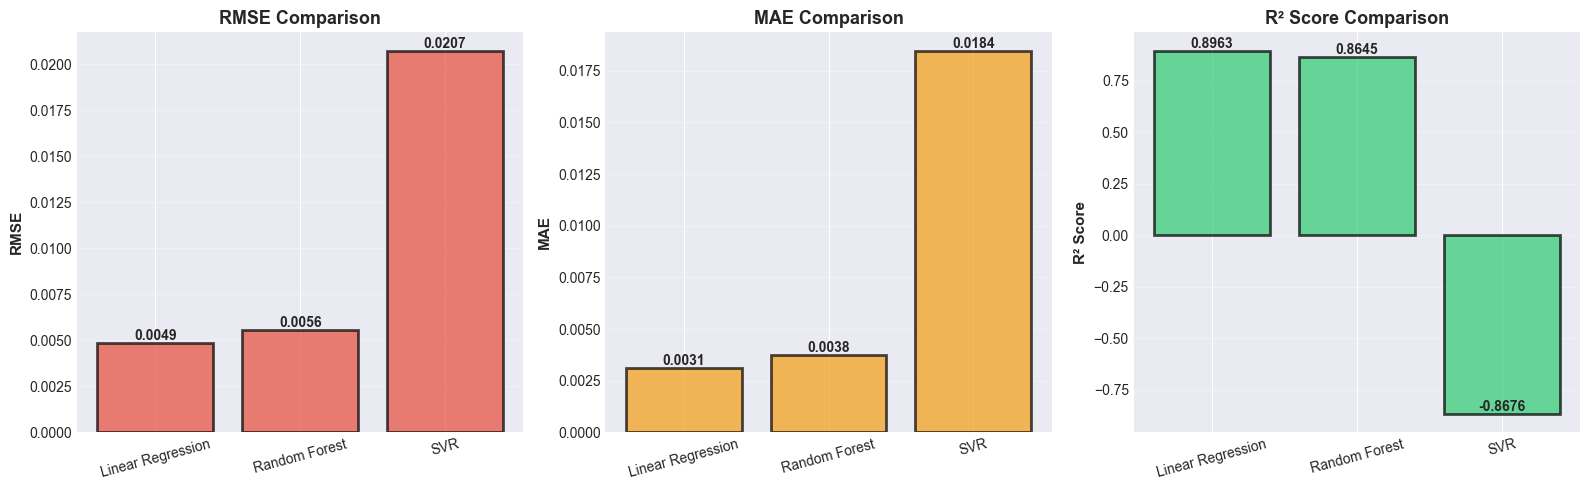

✅ Saved: 04_volatility_model_comparison.png


In [11]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

metrics = ['RMSE', 'MAE', 'R² Score']
colors = ['#e74c3c', '#f39c12', '#2ecc71']

for i, metric in enumerate(metrics):
    bars = axes[i].bar(results_reg['Model'], results_reg[metric], 
                       color=colors[i], alpha=0.7, edgecolor='black', linewidth=2)
    axes[i].set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    axes[i].set_ylabel(metric, fontsize=11, fontweight='bold')
    axes[i].grid(alpha=0.3, axis='y')
    axes[i].tick_params(axis='x', rotation=15)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('/Users/aryan/Desktop/Stock-Price-Volatility-Sentiment-ML/visualizations/04_volatility_model_comparison.png',
           dpi=300, bbox_inches='tight')
plt.show()

print('✅ Saved: 04_volatility_model_comparison.png')

## Step 11: Predicted vs Actual Volatility

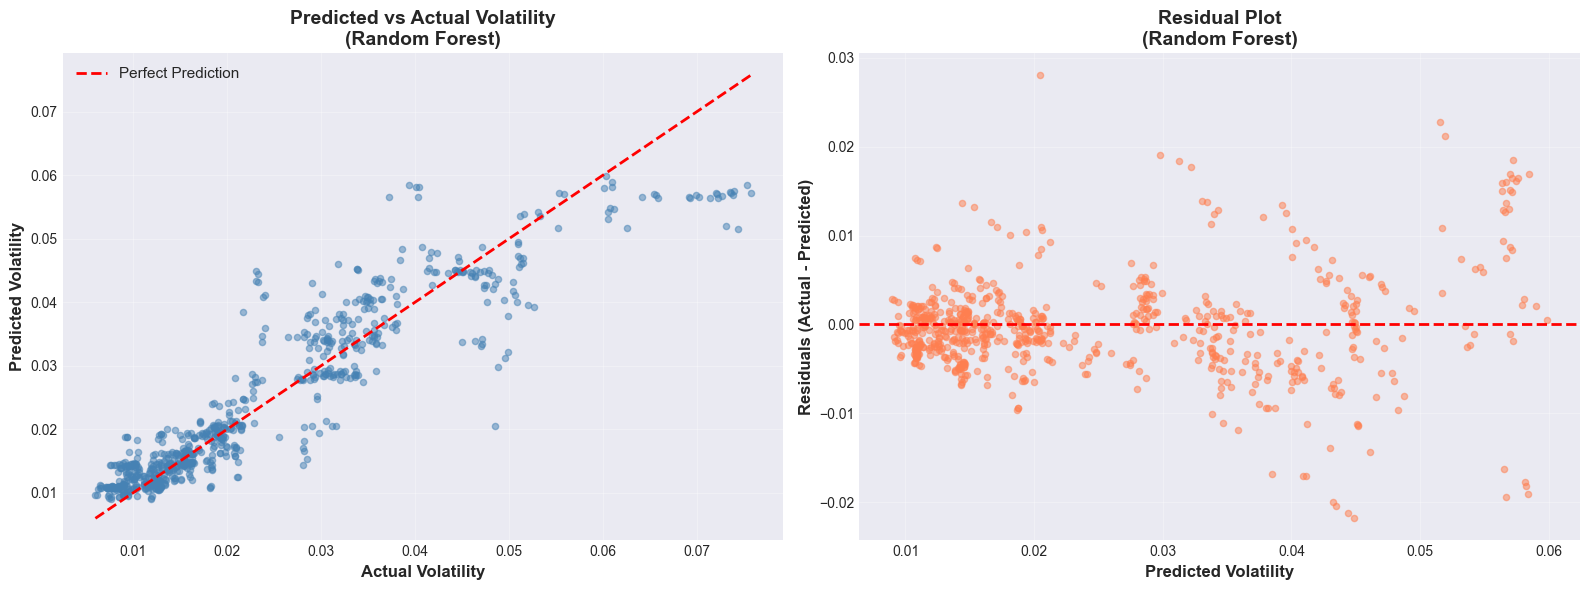

✅ Saved: 04_predicted_vs_actual.png


In [12]:
# Use best model predictions (let's use Random Forest as example)
best_predictions = y_pred_rf_test

# Plot predicted vs actual
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
axes[0].scatter(y_test, best_predictions, alpha=0.5, s=20, color='steelblue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
            'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Volatility', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted Volatility', fontsize=12, fontweight='bold')
axes[0].set_title('Predicted vs Actual Volatility\n(Random Forest)', 
                 fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Residual plot
residuals = y_test - best_predictions
axes[1].scatter(best_predictions, residuals, alpha=0.5, s=20, color='coral')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Volatility', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Residuals (Actual - Predicted)', fontsize=12, fontweight='bold')
axes[1].set_title('Residual Plot\n(Random Forest)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/aryan/Desktop/Stock-Price-Volatility-Sentiment-ML/visualizations/04_predicted_vs_actual.png',
           dpi=300, bbox_inches='tight')
plt.show()

print('✅ Saved: 04_predicted_vs_actual.png')

## Step 12: Time Series Visualization

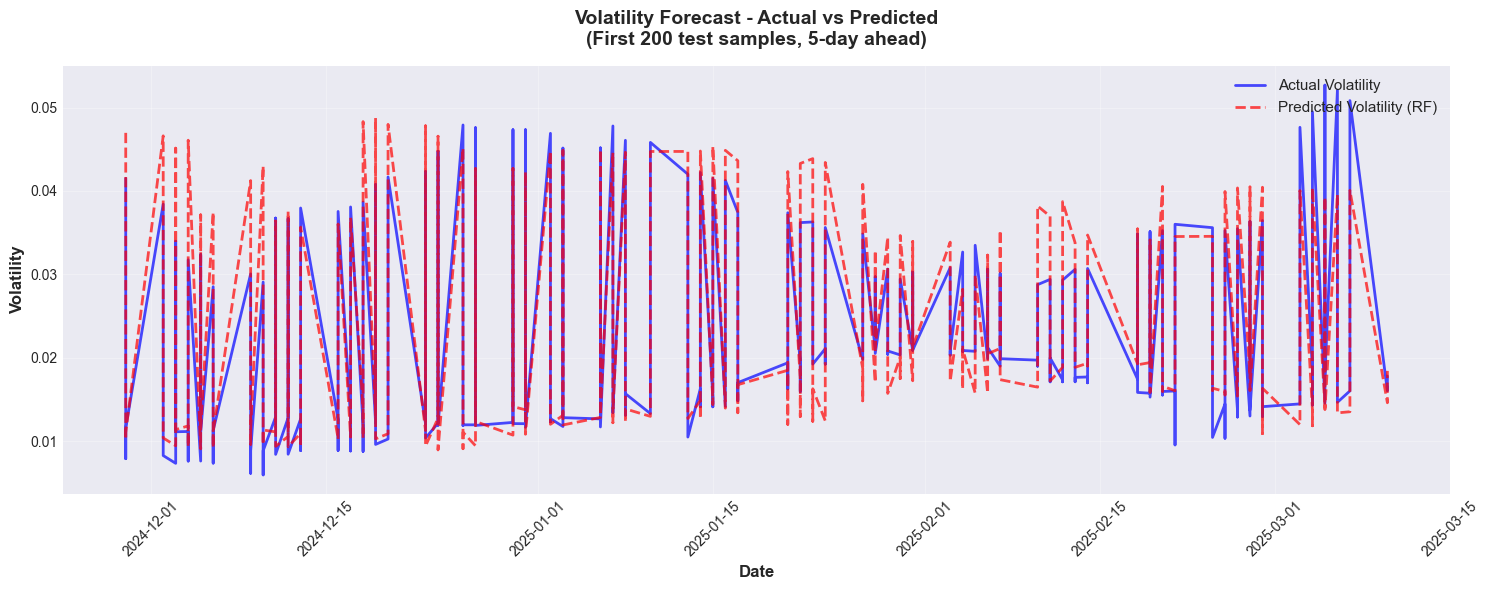

✅ Saved: 04_time_series_forecast.png


In [13]:
# Plot time series of actual vs predicted (first 200 test samples)
n_samples = min(200, len(y_test))
test_dates = test_df['Date'].values[:n_samples]

plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test[:n_samples], label='Actual Volatility', 
        linewidth=2, color='blue', alpha=0.7)
plt.plot(test_dates, best_predictions[:n_samples], label='Predicted Volatility (RF)', 
        linewidth=2, color='red', alpha=0.7, linestyle='--')

plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Volatility', fontsize=12, fontweight='bold')
plt.title(f'Volatility Forecast - Actual vs Predicted\n(First {n_samples} test samples, {forecast_horizon}-day ahead)', 
         fontsize=14, fontweight='bold', pad=15)
plt.legend(fontsize=11, loc='upper right')
plt.grid(alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('/Users/aryan/Desktop/Stock-Price-Volatility-Sentiment-ML/visualizations/04_time_series_forecast.png',
           dpi=300, bbox_inches='tight')
plt.show()

print('✅ Saved: 04_time_series_forecast.png')

## Step 13: Feature Importance (Random Forest)

TOP 10 MOST IMPORTANT FEATURES FOR VOLATILITY PREDICTION
       Feature  Importance
 Volatility_20    0.914388
      BB_Width    0.020392
           RSI    0.008722
          MACD    0.006894
   MACD_Signal    0.006546
High_Low_Range    0.005739
     MACD_Hist    0.005579
        Volume    0.005346
        EMA_50    0.004782
      BB_Upper    0.003417


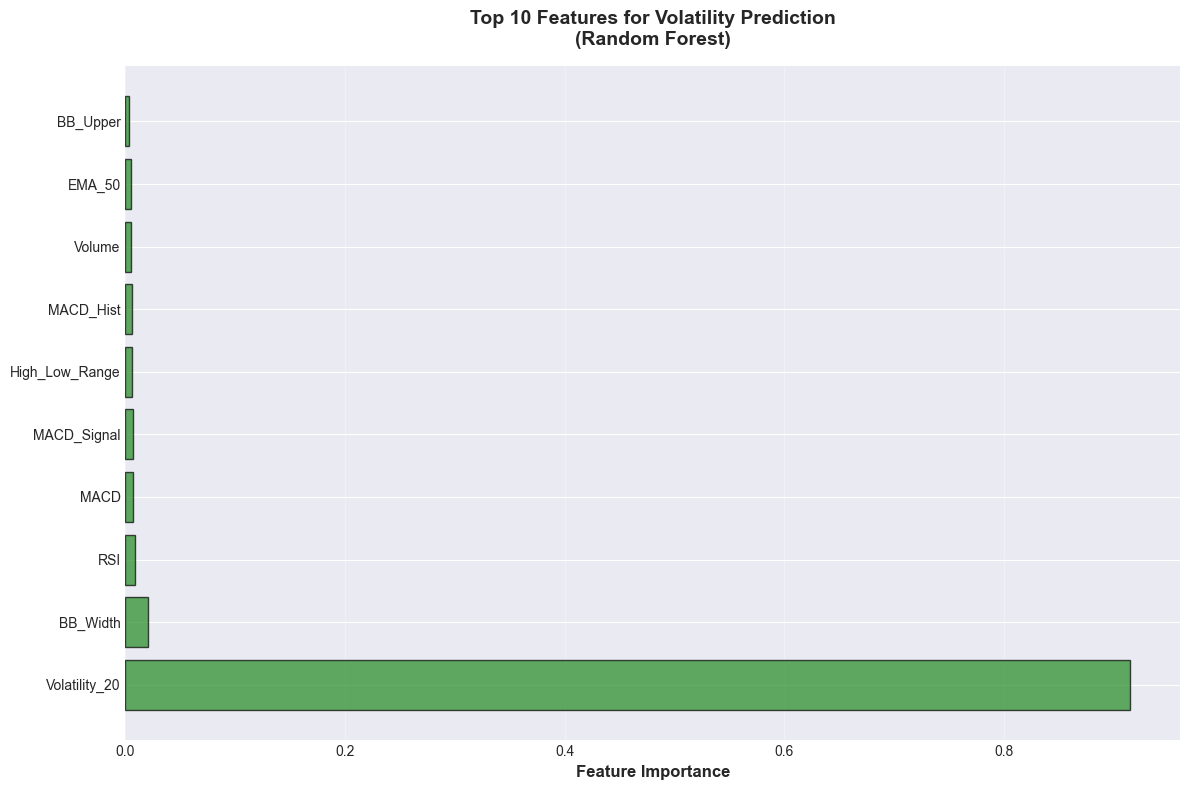


✅ Saved: 04_feature_importance.png


In [14]:
# Get feature importance from Random Forest
feature_importance = rf_model.feature_importances_

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importance
})

importance_df = importance_df.sort_values('Importance', ascending=False)

print('='*70)
print('TOP 10 MOST IMPORTANT FEATURES FOR VOLATILITY PREDICTION')
print('='*70)
print(importance_df.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(12, 8))
top_10 = importance_df.head(10)
plt.barh(range(len(top_10)), top_10['Importance'], color='forestgreen', alpha=0.7, edgecolor='black')
plt.yticks(range(len(top_10)), top_10['Feature'])
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
plt.title('Top 10 Features for Volatility Prediction\n(Random Forest)', 
         fontsize=14, fontweight='bold', pad=15)
plt.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('/Users/aryan/Desktop/Stock-Price-Volatility-Sentiment-ML/visualizations/04_feature_importance.png',
           dpi=300, bbox_inches='tight')
plt.show()

print('\n✅ Saved: 04_feature_importance.png')

## Step 14: Save Models

In [15]:
print('\n' + '='*70)
print('SAVING VOLATILITY REGRESSION MODELS')
print('='*70)

# Create models directory
import os
models_dir = '/Users/aryan/Desktop/Stock-Price-Volatility-Sentiment-ML/models'
os.makedirs(models_dir, exist_ok=True)

# Save all models
joblib.dump(lr_model, f'{models_dir}/volatility_linear_regression.pkl')
joblib.dump(rf_model, f'{models_dir}/volatility_random_forest.pkl')
joblib.dump(svr_model, f'{models_dir}/volatility_svr.pkl')
joblib.dump(scaler_reg, f'{models_dir}/volatility_scaler.pkl')

print('\n✅ Models saved successfully!')
print('   - volatility_linear_regression.pkl')
print('   - volatility_random_forest.pkl')
print('   - volatility_svr.pkl')
print('   - volatility_scaler.pkl')
print(f'\nLocation: {models_dir}')


SAVING VOLATILITY REGRESSION MODELS

✅ Models saved successfully!
   - volatility_linear_regression.pkl
   - volatility_random_forest.pkl
   - volatility_svr.pkl
   - volatility_scaler.pkl

Location: /Users/aryan/Desktop/Stock-Price-Volatility-Sentiment-ML/models
